In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
import datetime

import random
import pickle

from sklearn.metrics import mean_squared_error

import openpyxl
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
!pip install shap
import shap

import statistics

In [2]:
#from google.colab import drive
#drive.mount('/content/drive/')
#path = '/content/drive/MyDrive/01_Statistical_Science/Thesis'
path = ''

In [3]:
df_top20 = pd.read_csv(path+'Data/df_top20.csv')
df_complex_complete = pd.DataFrame()

for i in df_top20.groupby('PULocationID'):
    A = i[1]

    df_complex = pd.concat([A['datetime'], A['PULocationID'], A['PULocationID'].astype(str)+'-'+A['pickup_day_of_week'].astype(str), np.cos((A['pickup_hour']*2*np.pi)/24), 
           np.sin((A['pickup_hour']*2*np.pi)/24), np.cos((A['pickup_hour']*2*np.pi)/12),  np.sin((A['pickup_hour']*2*np.pi)/12), A['count'], 
           A['count'].shift(1), A['count'].shift(2),A['count'].shift(3), A['count'].shift(4),A['count'].shift(5), A['count'].shift(6), 
           A['count'].shift(7), A['count'].shift(8), A['count'].shift(9), A['count'].shift(10),A['count'].shift(11), A['count'].shift(12), 
           A['count'].shift(13), A['count'].shift(14), A['count'].shift(15), A['count'].shift(16), A['count'].shift(17), A['count'].shift(18), 
           A['count'].shift(19), A['count'].shift(20), A['count'].shift(21), A['count'].shift(22),   A['count'].shift(23), A['count'].shift(24), 
           A['count'].shift(168), A['count'].shift(336), A['count'].shift(504), A['count'].shift(672)], axis = 1)

    df_complex.columns = ['datetime', 'PULocationID', 'categorical', 'cos_hour', 'sin_hour', 'cos_month', 'sin_month', 'y', 'y-1', 'y-2', 'y-3', 'y-4',
                      'y-5', 'y-6', 'y-7', 'y-8', 'y-9', 'y-10', 'y-11', 'y-12','y-13', 'y-14', 'y-15', 'y-16','y-17', 'y-18', 'y-19', 'y-20',
                      'y-21', 'y-22', 'y-23', 'y-24', 'y-1w', 'y-2w', 'y-3w', 'y-4w']
    df_complex_complete = df_complex_complete.append(df_complex, ignore_index = True) 

df_final = df_complex_complete.join(pd.get_dummies(df_complex_complete['categorical'])).dropna()
df_final.sort_values(['PULocationID', 'datetime'], inplace = True)

In [4]:
# Metrics
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

def rmse(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return(np.sqrt(mean_squared_error(actual,forecast)))

def PRE(actual, pred):
    return np.abs(actual-pred)/actual    

In [5]:
R = np.linspace(0, .5234375)
G = np.linspace(0, .734375)
B = np.linspace(0, .14453125)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
  red_list.append((x[i], R[i], R[i]))
  green_list.append((x[i], G[i], G[i]))
  blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict = LinearSegmentedColormap('cdict', cdict)

R = np.linspace(.5234375, 0)
G = np.linspace(.734375, 0)
B = np.linspace(.14453125, 0)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
  red_list.append((x[i], R[i], R[i]))
  green_list.append((x[i], G[i], G[i]))
  blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict_r = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict_r = LinearSegmentedColormap('cdict_r', cdict_r)

# Model configurations

In [6]:
# XGBoost
params = [0.06759574377750831,82,8,3.247253370691017, 0.04770505824520567,0.6854091260991332, 0.8344206263318037]

In [7]:
# prediction models
def naive(X):
    return X['y-1']

def xgboost(X):
    return xgb_model.predict(X.values.reshape(1,172), validate_features = False)[0]

# MAB Procedure

In [8]:
# MAB Procedure
class MAB(object):
    """Base selector
    
    Args:
        models (dict): a dictionary of models from which the selector must choose at every
            call to ``select``.
        learning_strategy (func): a funct that represents the learning strategy utilized
            by the selector at every call to ``select``.
    """
    def __init__(self, models, learning_strategy):
        self.models = models
        self.ls = learning_strategy
        self.scores = dict.fromkeys(models.keys(), [1])
        self.history_model = []
        self.history_score = []
        self.history_pred = []
        self.history_y = []
        
        # change for zone specifity
        self.zone = [9999]

    def select(self, **kwargs):
        return max(self.scores, key=lambda i: self.ls([i, self.scores[i], self.history_model, self.history_score], **kwargs))
    
    def procedure(self, series, **kwargs):
        X = series.iloc[~series.index.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
        y = series['y']
        
        random_number = random.random()
        model = self.select(random_number = random_number, **kwargs)
        pred = max(0, self.models[model](X))
        percentage_error = np.abs(y-pred)/y
        percentage_accur = 1 - percentage_error
        self.scores[model] = self.scores[model] + [percentage_accur]
        
        self.history_model.append(model)
        self.history_pred.append(pred)
        self.history_score.append(percentage_accur)
        self.history_y.append(y)
        
    def execute(self, df, **kwargs):
        df.apply(self.procedure, **kwargs, axis = 1)
        
    def procedure_zone_reset(self, series, **kwargs):
        self.zone.append(series.loc['PULocationID'])
        X = series.iloc[~series.index.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
        y = series['y']
        
        if self.zone[-1] != self.zone[-2]:
            self.scores = dict.fromkeys(models.keys(), [1])
        
        random_number = random.random()
        model = self.select(random_number = random_number, **kwargs)
        pred = max(0, self.models[model](X))
        percentage_error = np.abs(y-pred)/y
        percentage_accur = 1 - percentage_error
        self.scores[model] = self.scores[model] + [percentage_accur]
        
        self.history_model.append(model)
        self.history_pred.append(pred)
        self.history_score.append(percentage_accur)
        self.history_y.append(y)
        
    def execute_zone_reset(self, df, **kwargs):
        df.apply(self.procedure_zone_reset, **kwargs, axis = 1)

In [9]:
# learning strategies
def ls_xgboost(list, random_number):
    if list[0] == 'xgb':
        return 1
    else:
        return 0
    
def ls_naive(list, random_number):
    if list[0] == 'naive':
        return 1
    else:
        return 0

def last(list):
    return list[1][-1]

def epsg(list, random_number, epsilon = 0.15, epoch_length = 168):
    if (random_number <= epsilon):
        r = random.random()
        return r
    
    else:
        model = list[0]
        score_list = list[1]
        history_models = list[2]
        
        epoch = (len(history_models)) % epoch_length
        if epoch == 0:
            epoch = epoch_length
        occurence = history_models[-epoch:].count(model)
        epoch_mean = np.mean(score_list[-occurence:])
        
        return epoch_mean
    
def ucb(list, random_number, alpha = 0.5, sw_length = 168):
    model = list[0]
    score_list = list[1]
    history_models = list[2]

    N = history_models[-sw_length:].count(model)
    sliding_score_list = score_list[-N:]
    average_accuracy = np.mean(sliding_score_list)
    N_m = len(sliding_score_list)
    v = len(history_models)+1
    
    padding = np.sqrt(alpha * np.log(min(v, sw_length)) / N_m)
    return average_accuracy + padding

In [10]:
def custom(list, random_number, threshold = -2.7, period = 24):
    model = list[0]
    score_list = list[1]
    history_models = list[2]
    count_naive = history_models[-period:].count('naive')
    
    if len(history_models) == 0:
        return 1
    
    else:
        if history_models[-1] == 'xgb':
            if model == 'xgb':
                if score_list[-1]<= threshold:
                    return 0
                else:
                    return 1
            if model == 'naive':
                return 0.5

        if history_models[-1] == 'naive':
            if model == 'naive':
                if count_naive == period:
                    return 0
                else:
                    return 1
            if model == 'xgb':
                if count_naive == period:
                    return 1
                else:
                    return 0

In [14]:
### Custom
years = range(2011, 2012)
selector_year = []
thresholds = [-2.3, -2.5, -2.7, -2.9, -3.1]
periods = [i for i in range(1, 33)]
for j in years:
    for t in thresholds:
        for p in periods:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'xgb':xgboost, 'naive':naive}
            selector = MAB(models, custom)
            selector.execute_zone_reset(df_test_j, threshold = t, period = p)
            selector_year.append(selector)

            print(j, t, p, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  10:38:17.157775
2011 -2.3 1  | Finished   |  10:40:16.154556  |  10.73840427283693
2011  | Predicting |  10:40:16.569037
2011 -2.3 2  | Finished   |  10:42:27.239168  |  10.709889653580046
2011  | Predicting |  10:42:27.693591
2011 -2.3 3  | Finished   |  10:44:37.095725  |  10.695737055529248
2011  | Predicting |  10:44:37.499501
2011 -2.3 4  | Finished   |  10:46:27.810735  |  10.687354205264166
2011  | Predicting |  10:46:28.227219
2011 -2.3 5  | Finished   |  10:48:42.778708  |  10.687344666311553
2011  | Predicting |  10:48:43.269545
2011 -2.3 6  | Finished   |  10:51:03.531840  |  10.68148204893467
2011  | Predicting |  10:51:03.965835
2011 -2.3 7  | Finished   |  10:53:07.714910  |  10.67417954996635
2011  | Predicting |  10:53:08.139200
2011 -2.3 8  | Finished   |  10:55:17.272774  |  10.669812573755824
2011  | Predicting |  10:55:17.797239
2011 -2.3 9  | Finished   |  10:57:23.773398  |  10.662622617347305
2011  | Predicting |  10:57:24.301438
2011 -2.3 1

2011  | Predicting |  13:13:34.570252
2011 -2.7 14  | Finished   |  13:15:28.165222  |  10.657922206578835
2011  | Predicting |  13:15:28.710770
2011 -2.7 15  | Finished   |  13:17:19.751200  |  10.657213280046028
2011  | Predicting |  13:17:20.307197
2011 -2.7 16  | Finished   |  13:19:34.443409  |  10.655907257051776
2011  | Predicting |  13:19:35.049470
2011 -2.7 17  | Finished   |  13:21:23.386544  |  10.652483672941546
2011  | Predicting |  13:21:23.942716
2011 -2.7 18  | Finished   |  13:23:38.255601  |  10.64956637571231
2011  | Predicting |  13:23:38.831375
2011 -2.7 19  | Finished   |  13:25:36.097558  |  10.648836476323028
2011  | Predicting |  13:25:36.799451
2011 -2.7 20  | Finished   |  13:27:32.905169  |  10.649177619124695
2011  | Predicting |  13:27:33.480798
2011 -2.7 21  | Finished   |  13:29:29.698266  |  10.64888175671388
2011  | Predicting |  13:29:30.284950
2011 -2.7 22  | Finished   |  13:31:36.899995  |  10.64746148577402
2011  | Predicting |  13:31:37.646136
20

2011  | Predicting |  15:54:13.493037
2011 -3.1 27  | Finished   |  15:56:25.930045  |  10.6510941005597
2011  | Predicting |  15:56:26.403097
2011 -3.1 28  | Finished   |  15:58:22.780374  |  10.651693415744388
2011  | Predicting |  15:58:23.288015
2011 -3.1 29  | Finished   |  16:00:18.300783  |  10.654398309898582
2011  | Predicting |  16:00:18.738612
2011 -3.1 30  | Finished   |  16:02:36.107744  |  10.656737941303788
2011  | Predicting |  16:02:36.571685
2011 -3.1 31  | Finished   |  16:04:34.177450  |  10.659211497841296
2011  | Predicting |  16:04:34.640212
2011 -3.1 32  | Finished   |  16:06:48.697173  |  10.661470901861257


In [19]:
xgb_only = pickle.load(open(path+"Results/xgb_only.dat", "rb"))
naive_only = pickle.load(open(path+"Results/naive_only.dat", "rb"))

#results_grid_custom = pickle.load(open('custom_final_grid.dat', "rb"))
model_history_hurricane = pickle.load(open(path+'Data/model_hurricane.dat', "rb"))

In [20]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

xgb_preds = []
naive_preds = []

for i in range(len(xgb_only)):
  xgb_year_preds = xgb_only[i].history_pred
  naive_year_preds = naive_only[i].history_pred
  xgb_preds.append(xgb_year_preds)
  naive_preds.append(naive_year_preds)

df_test.sort_values(['year', 'PULocationID', 'datetime'], inplace = True)
df_test['xgb'] = [item for elem in xgb_preds for item in elem]
df_test['naive'] = [item for elem in naive_preds for item in elem]

df_year = df_test[df_test['year']==2011]

In [27]:
def PlotTuningResults3D(results, parameter1, parameter2, metric, type = 'specific'):
    if type == 'broad':
      epsilons = np.repeat([0.001, 0.01, 0.1], 7)
      epochs = np.array([1, 24, 168, 672, 2016, 4032, 8760]*3)

      alphas = np.repeat([0.01, 0.1, .5, 1], 7)
      sws = np.array([1, 24, 168, 672, 2016, 4032, 8760]*4)
    
    else:
      epsilons = np.repeat([i/1000 for i in range(1, 16)], 16)
      epochs = np.array([i for i in range(1, 33, 2)]*15)

      #alphas = np.repeat([0, 0.2, 0.4, 0.6, 0.8, 1], 5)
      #sws = np.array([1, 2, 3, 4, 5]*6)
      alphas = np.repeat([.9, .93, .95, .97, 1, 1.03, 1.05, 1.07, 1.09], 5)
      sws = np.array([8088, 8640, 8736, 8760, 8784]*9)

      thresholds = np.repeat([-2.3, -2.5, -2.7, -2.9, -3.1], 32)
      periods = np.array([i for i in range(1, 33)]*5)


    df = pd.DataFrame([smape(x.history_y,x.history_pred) for x in results])
    if parameter1 == 'epsilon':
      df[parameter1] = epsilons
      df['epoch'] = epochs
      df.columns = ['smape', 'epsilon', 'epoch']
    if parameter1 == 'alpha':
      df[parameter1] = alphas
      df[parameter2] = sws
      df.columns = ['smape', 'alpha', 'sw']
    if parameter1 == 'threshold':
      df[parameter1] = thresholds
      df[parameter2] = periods
      df.columns = ['smape', 'threshold', 'period']
    df['mimic_optimal'] = [np.sum(np.array(model_history_hurricane) == np.array(x.history_model))/len(model_history_hurricane)*100 for x in results]
    df['rmse'] = [rmse(x.history_y,x.history_pred) for x in results]

    m = len(df[parameter1].unique())
    n = len(df[parameter2].unique())

    X = df[parameter1].to_numpy(dtype = float).reshape([m, n])
    Y = df[parameter2].to_numpy().reshape([m, n])
    Z = df.pivot_table(index = [parameter1], columns = parameter2, values = metric)
    
    Z = np.array(Z, dtype = float)
    
    fig = plt.figure(figsize = (12,8))
    ax = fig.gca(projection='3d')

    # Plot the surface.
    if metric == 'mimic_optimal':
      surf = ax.plot_surface(X, Y, Z, cmap=cdict,
                       linewidth=0, antialiased=False)
    else: 
            surf = ax.plot_surface(X, Y, Z, cmap=cdict_r,
                       linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if parameter1 ==  'epsilon':
      ax.set_xlabel('Epoch', size = 13)
    if parameter1 == 'alpha':
      ax.set_xlabel('Alpha', size = 13)
    if parameter1 == 'threshold':
      ax.set_xlabel('Threshold', size = 13)
    if parameter2 == 'sw':
      ax.set_ylabel('Sliding Window Size', size = 13)
    if parameter2 == 'epoch':
      ax.set_ylabel('Epoch length', size = 13)
    if parameter2 == 'period':
      ax.set_ylabel('Period', size = 13)
    if metric == 'smape':
      ax.set_zlabel('SMAPE', size = 13)
    if metric == 'mimic_optimal':
      ax.set_zlabel('% Equal to Optimal Predictions', size = 13)
    if metric == 'rmse':
      ax.set_zlabel('RMSE', size = 13)
    plt.show()

    return df.sort_values('smape')

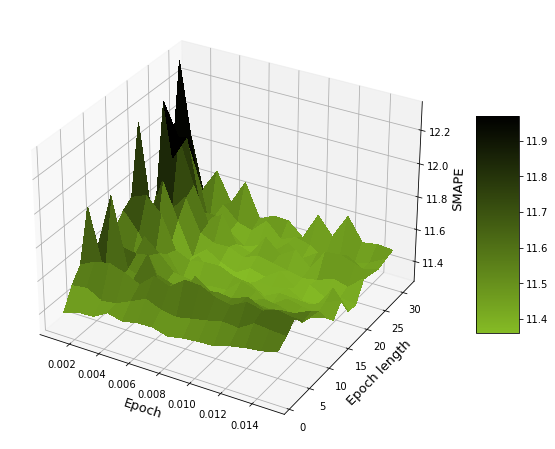

In [28]:
gride_epoch_df = PlotTuningResults3D(selector_year, 'epsilon', 'epoch', 'smape')

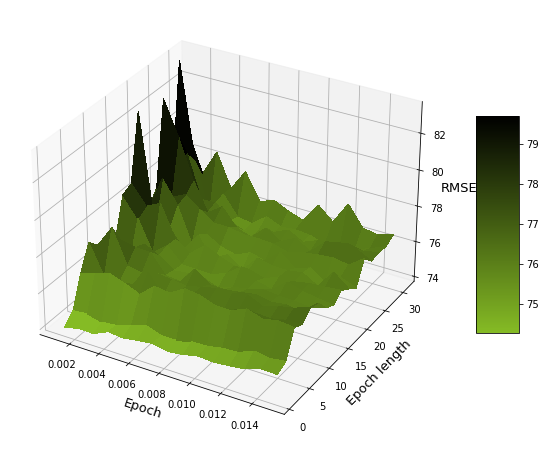

In [29]:
gride_epoch_df = PlotTuningResults3D(selector_year, 'epsilon', 'epoch', 'rmse')

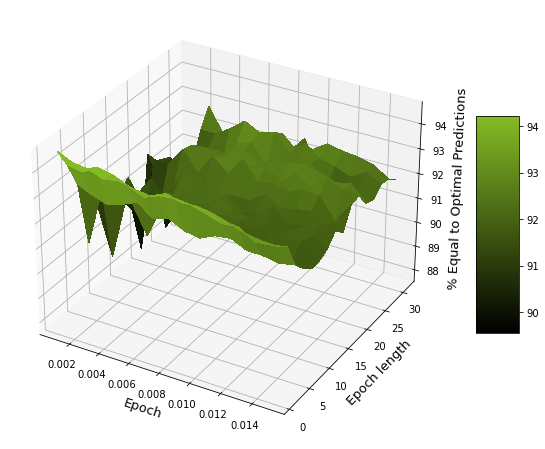

In [31]:
gride_epoch_df = PlotTuningResults3D(selector_year, 'epsilon', 'epoch', 'mimic_optimal')

In [33]:
print(gride_epoch_df[['epoch', 'epsilon', 'smape', 'rmse', 'mimic_optimal']].sort_values('smape').head(10).to_latex(index = False, float_format = "%.3f"))

\begin{tabular}{rrrrr}
\toprule
 epoch &  epsilon &  smape &   rmse &  mimic\_optimal \\
\midrule
    19 &    0.008 & 11.298 & 75.222 &         93.147 \\
    19 &    0.006 & 11.325 & 75.171 &         92.928 \\
    19 &    0.004 & 11.327 & 75.379 &         92.875 \\
    21 &    0.007 & 11.350 & 75.440 &         92.939 \\
    27 &    0.006 & 11.357 & 75.381 &         93.308 \\
    21 &    0.013 & 11.360 & 75.399 &         92.949 \\
    19 &    0.013 & 11.361 & 75.595 &         92.525 \\
    19 &    0.012 & 11.362 & 76.077 &         92.620 \\
    29 &    0.011 & 11.362 & 75.428 &         92.934 \\
    15 &    0.006 & 11.364 & 75.570 &         92.596 \\
\bottomrule
\end{tabular}



In [34]:
print(gride_epoch_df[['epoch', 'epsilon', 'smape', 'rmse', 'mimic_optimal']].sort_values('rmse').head(10).to_latex(index = False, float_format = "%.3f"))

\begin{tabular}{rrrrr}
\toprule
 epoch &  epsilon &  smape &   rmse &  mimic\_optimal \\
\midrule
     1 &    0.001 & 11.392 & 73.927 &         94.729 \\
     1 &    0.003 & 11.425 & 74.117 &         94.375 \\
     1 &    0.002 & 11.421 & 74.148 &         94.450 \\
     3 &    0.003 & 11.470 & 74.319 &         94.173 \\
     3 &    0.004 & 11.483 & 74.403 &         94.040 \\
     1 &    0.005 & 11.453 & 74.411 &         94.254 \\
     3 &    0.001 & 11.510 & 74.450 &         93.914 \\
     1 &    0.008 & 11.449 & 74.462 &         94.283 \\
     1 &    0.004 & 11.476 & 74.497 &         94.150 \\
     3 &    0.002 & 11.521 & 74.529 &         93.821 \\
\bottomrule
\end{tabular}



best RMSE is also best mimic
Best sMAPE only best sMAPE

In [15]:
pickle.dump(selector_year, open(path+"custom_final_grid.dat", "wb"))

In [70]:
### Epsilon greedy
years = range(2011, 2021)
selector_year = []
epoch_lengths = [1]
tresholds = [.77]

for j in years:
    for epoch_length in epoch_lengths:
        for t in tresholds:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'xgb':xgboost, 'naive':naive}
            selector = MAB(models, custom)
            selector.execute_zone_reset(df_test_j, epoch_length = epoch_length, treshold = t)
            selector_year.append(selector)

            print(j, epoch_length, t, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  20:43:36.297127
2011 1 0.77  | Finished   |  20:45:35.141968  |  10.717627343871088
2012  | Predicting |  20:45:35.649809
2012 1 0.77  | Finished   |  20:47:34.558565  |  9.80594802186493
2013  | Predicting |  20:47:35.192918
2013 1 0.77  | Finished   |  20:49:48.845105  |  10.051135279113014
2014  | Predicting |  20:49:49.486396
2014 1 0.77  | Finished   |  20:52:13.428741  |  10.070207523930412
2015  | Predicting |  20:52:13.909949
2015 1 0.77  | Finished   |  20:54:23.928486  |  10.57298589532579
2016  | Predicting |  20:54:24.535398
2016 1 0.77  | Finished   |  20:56:12.700173  |  11.27870881969008
2017  | Predicting |  20:56:13.357587
2017 1 0.77  | Finished   |  20:58:03.380404  |  11.748086469294975
2018  | Predicting |  20:58:04.209721
2018 1 0.77  | Finished   |  20:59:53.508854  |  12.05698101883014
2019  | Predicting |  20:59:54.015513
2019 1 0.77  | Finished   |  21:01:44.103446  |  13.234747378117211
2020  | Predicting |  21:01:44.565739
2020 1 0.77  

In [29]:
### Custom if score-list[-1] <= 0
years = range(2011, 2021)
selector_year = []
epoch_lengths = [21]
for j in years:
    for epoch_length in epoch_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'xgb':xgboost, 'naive':naive}
            selector = MAB(models, custom)
            selector.execute_zone_reset(df_test_j, epoch_length = epoch_length)
            selector_year.append(selector)

            print(j, epoch_length, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  17:28:25.541663
2011 21  | Finished   |  17:30:34.115594  |  10.72691990410299
2012  | Predicting |  17:30:34.776322
2012 21  | Finished   |  17:32:42.565280  |  9.803718981324808
2013  | Predicting |  17:32:43.229402
2013 21  | Finished   |  17:34:52.819302  |  10.046470491386097
2014  | Predicting |  17:34:53.392882
2014 21  | Finished   |  17:37:18.617088  |  10.068461376810605
2015  | Predicting |  17:37:19.178666
2015 21  | Finished   |  17:39:33.067086  |  10.570291824742064
2016  | Predicting |  17:39:33.613836
2016 21  | Finished   |  17:42:01.131073  |  11.292324792511028
2017  | Predicting |  17:42:01.751856
2017 21  | Finished   |  17:44:07.772568  |  11.748042329943893
2018  | Predicting |  17:44:08.346546
2018 21  | Finished   |  17:46:11.316630  |  12.05187070230797
2019  | Predicting |  17:46:11.952709
2019 21  | Finished   |  17:48:20.889935  |  13.226714071282343
2020  | Predicting |  17:48:21.515773
2020 21  | Finished   |  17:50:25.281118  |  43

2020



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Text(0.5, 15.0, 'Taxi Zone'), Text(33.0, 0.5, 'Day of the Year')]

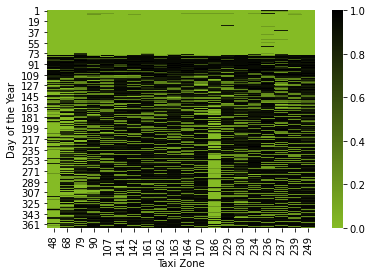

In [121]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

j = 0
years = [i for i in range(2020, 2021)]
df_test_year = df_test[df_test['year'] == years[j]]
print(years[j])

# model usage
model_selections = selector_year[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['epsg_selection'] = model_selections_bin
epsg_averages = df_test_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['doy'], columns = 'PULocationID', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Taxi Zone', ylabel = 'Day of the Year')

2016



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Text(0.5, 15.0, 'Taxi Zone'), Text(33.0, 0.5, 'Day of the Year')]

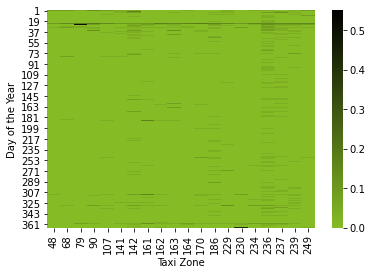

In [46]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

j = 5
years = [i for i in range(2011, 2021)]
df_test_year = df_test[df_test['year'] == years[j]]
print(years[j])

# EPSG model usage
model_selections = selector_year[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['epsg_selection'] = model_selections_bin
epsg_averages = df_test_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['doy'], columns = 'PULocationID', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Taxi Zone', ylabel = 'Day of the Year')

2020



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Text(0.5, 15.0, 'Taxi Zone'), Text(33.0, 0.5, 'Day of the Year')]

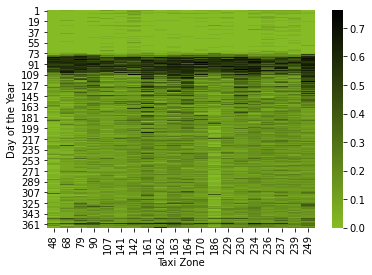

In [71]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

j = 9
years = [i for i in range(2011, 2021)]
df_test_year = df_test[df_test['year'] == years[j]]
print(years[j])

# EPSG model usage
model_selections = selector_year[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['epsg_selection'] = model_selections_bin
epsg_averages = df_test_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['doy'], columns = 'PULocationID', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Taxi Zone', ylabel = 'Day of the Year')

# Parameter Tuning

In [17]:
### Epsilon greedy
years = range(2011, 2012)
selector_year = []
epsilons = [i/1000 for i in range(1, 16)]
epoch_lengths = [i for i in range(1, 33, 2)]

for j in years:
    for epsilon in epsilons:
        for epoch_length in epoch_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, epsg)
            selector.execute_zone_reset(df_test_j, epsilon = epsilon, epoch_length = epoch_length)
            selector_year.append(selector)

            print(j, epsilon, epoch_length, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  11:53:38.094775
2011 0.001 1  | Finished   |  11:56:11.130241  |  11.391719597423153
2011  | Predicting |  11:56:11.698760
2011 0.001 3  | Finished   |  11:58:32.410945  |  11.5096896560464
2011  | Predicting |  11:58:32.884684
2011 0.001 5  | Finished   |  12:00:47.870552  |  11.591638822987653
2011  | Predicting |  12:00:48.512842
2011 0.001 7  | Finished   |  12:03:22.745487  |  11.896334336170163
2011  | Predicting |  12:03:23.303782
2011 0.001 9  | Finished   |  12:05:50.640802  |  11.613307317814831
2011  | Predicting |  12:05:51.151732
2011 0.001 11  | Finished   |  12:08:09.565877  |  11.547121190824205
2011  | Predicting |  12:08:10.035935
2011 0.001 13  | Finished   |  12:10:35.206087  |  11.632166940215837
2011  | Predicting |  12:10:35.634204
2011 0.001 15  | Finished   |  12:13:04.145564  |  11.70563646203017
2011  | Predicting |  12:13:04.582399
2011 0.001 17  | Finished   |  12:15:24.453397  |  11.747391846479328
2011  | Predicting |  12:15:24.90622

2011 0.005 25  | Finished   |  15:01:32.532840  |  11.576187603545108
2011  | Predicting |  15:01:32.980482
2011 0.005 27  | Finished   |  15:03:48.755445  |  11.422520949986213
2011  | Predicting |  15:03:49.210168
2011 0.005 29  | Finished   |  15:06:16.601355  |  11.440531011226588
2011  | Predicting |  15:06:17.091108
2011 0.005 31  | Finished   |  15:08:38.338018  |  11.652027007357407
2011  | Predicting |  15:08:38.829261
2011 0.006 1  | Finished   |  15:11:21.016421  |  11.47245132279954
2011  | Predicting |  15:11:21.528304
2011 0.006 3  | Finished   |  15:13:42.682922  |  11.567074535450624
2011  | Predicting |  15:13:43.203439
2011 0.006 5  | Finished   |  15:16:04.123522  |  11.658876477120986
2011  | Predicting |  15:16:04.606081
2011 0.006 7  | Finished   |  15:18:27.166229  |  11.499328959651686
2011  | Predicting |  15:18:27.644694
2011 0.006 9  | Finished   |  15:20:45.015376  |  11.522295307085622
2011  | Predicting |  15:20:45.722579
2011 0.006 11  | Finished   |  15:

2011  | Predicting |  09:08:44.385128
2011 0.01 19  | Finished   |  09:10:54.811599  |  11.387182709204628
2011  | Predicting |  09:10:55.333331
2011 0.01 21  | Finished   |  09:13:21.335036  |  11.443040859072916
2011  | Predicting |  09:13:21.773018
2011 0.01 23  | Finished   |  09:15:39.399527  |  11.39978787594082
2011  | Predicting |  09:15:39.849100
2011 0.01 25  | Finished   |  09:17:54.036763  |  11.487482428338415
2011  | Predicting |  09:17:54.495574
2011 0.01 27  | Finished   |  09:20:07.599052  |  11.389820492833934
2011  | Predicting |  09:20:08.263827
2011 0.01 29  | Finished   |  09:22:26.986923  |  11.427139579700839
2011  | Predicting |  09:22:27.427972
2011 0.01 31  | Finished   |  09:24:43.175616  |  11.57494547995252
2011  | Predicting |  09:24:43.603184
2011 0.011 1  | Finished   |  09:27:07.576760  |  11.479840608896469
2011  | Predicting |  09:27:08.185106
2011 0.011 3  | Finished   |  09:29:26.234163  |  11.574334190472102
2011  | Predicting |  09:29:26.676545
2

2011 0.015 11  | Finished   |  12:23:46.102076  |  11.568524871242907
2011  | Predicting |  12:23:46.601722
2011 0.015 13  | Finished   |  12:26:14.983381  |  11.481648261190706
2011  | Predicting |  12:26:15.488124
2011 0.015 15  | Finished   |  12:29:05.619258  |  11.420600591997854
2011  | Predicting |  12:29:06.087026
2011 0.015 17  | Finished   |  12:31:29.957287  |  11.491188588897204
2011  | Predicting |  12:31:30.436970
2011 0.015 19  | Finished   |  12:33:50.422035  |  11.38233304943706
2011  | Predicting |  12:33:50.888157
2011 0.015 21  | Finished   |  12:36:12.812968  |  11.375407564465744
2011  | Predicting |  12:36:13.273776
2011 0.015 23  | Finished   |  12:38:36.326376  |  11.489581479855175
2011  | Predicting |  12:38:36.806990
2011 0.015 25  | Finished   |  12:40:57.799792  |  11.475745530885616
2011  | Predicting |  12:40:58.271533
2011 0.015 27  | Finished   |  12:43:15.756521  |  11.460326870947311
2011  | Predicting |  12:43:16.389506
2011 0.015 29  | Finished   |

In [18]:
pickle.dump(selector_year, open(path+"Results/epsg_grid_narrow_0107.dat", "wb"))

In [22]:
### UCB
years = [2016]
selector_year = []
alphas = [1.045]
sw_lengths = [8760]

for j in years:
    for alpha in alphas:
        for sw in sw_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, ucb)
            selector.execute_zone_reset(df_test_j, alpha = alpha, sw_length = sw)
            selector_year.append(selector)

            print(j, alpha, sw, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2016  | Predicting |  16:08:10.663884
2016 1.045 8760  | Finished   |  16:11:38.727150  |  19.720604974036224


In [41]:
pickle.dump(selector_year, open(path+"Results/ucb_grid_narrow2.dat", "wb"))

In [ ]:
0 1 11.39626
1 672 14.322
1.1 8760 10.909
1.07 8760 10.89

In [ ]:
\begin{tabular}{rrrlllrrlll}
\hline
Year                      & \multicolumn{5}{c}{SMAPE}                                                       & \multicolumn{5}{c}{RMSE}                                                        \\ \cline{2-11} 
\multicolumn{1}{l}{}      & \multicolumn{1}{l}{XGBoost} & \multicolumn{1}{l}{Naive} & Epsg  & UCB-d & UCB-f & \multicolumn{1}{l}{XGBoost} & \multicolumn{1}{l}{Naive} & Epsg  & UCB-d & UCB-f \\ \cline{2-11} 
2012                      & 9.77                        & 26.41                     & 10.41 & 10.33 & 10.05 & 67.84                       & 153.18                    & 72.05 & 69.93 & 69.88 \\
2013                      & 10.00                       & 26.61                     & 10.60 & 10.45 & 10.26 & 68.12                       & 151.45                    & 72.04 & 69.96 & 69.87 \\
2014                      & 10.03                       & 26.18                     & 10.62 & 10.51 & 10.24 & 65.43                       & 142.40                    & 69.16 & 67.05 & 66.72 \\
2015                      & 10.55                       & 26.12                     & 11.07 & 10.96 & 13.70 & 61.23                       & 126.60                    & 64.77 & 62.82 & 79.64 \\
2016                      & 11.27                       & 26.19                     & 11.87 & 12.72 & 19.23 & 57.80                       & 115.55                    & 61.53 & 65.05 & 94.46 \\
2017                      & 11.61                       & 26.60                     & 12.72 & 12.90 & 13.51 & 52.00                       & 102.05                    & 57.81 & 56.83 & 60.58 \\
2018                      & 11.89                       & 27.43                     & 12.80 & 12.77 & 12.16 & 47.74                       & 94.17                     & 51.53 & 49.29 & 48.70 \\
2019                      & 13.01                       & 28.55                     & 14.08 & 14.01 & 13.27 & 42.19                       & 79.91                     & 45.37 & 43.46 & 42.82 \\
2020                      & 51.26                       & 39.01                     & 38.13 & 40.47 & 37.46 & 28.71                       & 39.17                     & 26.70 & 25.86 & 25.56 \\ \hline
\multicolumn{1}{l}{Total} & \multicolumn{1}{l}{15.31}       & \multicolumn{1}{l}{28.07}     & 14.58 & 14.89 & 15.44 & \multicolumn{1}{l}{56.08}       & \multicolumn{1}{l}{117.29}    & 59.67 & 58.5 & 65.13    
\end{tabular}

In [ ]:
smape: 15.31 28.07 14.58 14.89 15.44
rmse: 56.08 117.29 59.67 58.5 65.13

# Evaluation Test Data

In [38]:
### Epsilon greedy Evaluation Test Data
years = range(2011, 2021)
selector_year = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, epsg)
    selector.execute_zone_reset(df_test_j, epsilon = 0.008, epoch_length = 19)
    selector_year.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  15:10:34.065997
2011  | Finished   |  15:12:57.838901  |  11.47087519659298
2012  | Predicting |  15:12:58.486401
2012  | Finished   |  15:15:15.455470  |  10.430841721382249
2013  | Predicting |  15:15:16.087809
2013  | Finished   |  15:18:01.973652  |  10.654361637731762
2014  | Predicting |  15:18:02.569169
2014  | Finished   |  15:20:19.349945  |  10.612081230483117
2015  | Predicting |  15:20:19.903397
2015  | Finished   |  15:23:04.963468  |  11.122976936620915
2016  | Predicting |  15:23:05.612896
2016  | Finished   |  15:25:28.677971  |  12.067839825417815
2017  | Predicting |  15:25:29.199140
2017  | Finished   |  15:27:53.279515  |  12.604375129012169
2018  | Predicting |  15:27:53.790170
2018  | Finished   |  15:30:49.139599  |  12.83939507792201
2019  | Predicting |  15:30:49.683761
2019  | Finished   |  15:33:05.413298  |  14.3199911387217
2020  | Predicting |  15:33:06.085040
2020  | Finished   |  15:35:39.871791  |  38.147665527328314


In [37]:
### Epsilon greedy Evaluation Test Data
years = range(2011, 2021)
selector_year = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, epsg)
    selector.execute_zone_reset(df_test_j, epsilon = 0.001, epoch_length = 1)
    selector_year.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  14:12:16.814473
2011  | Finished   |  14:14:51.203502  |  11.405947335697697
2012  | Predicting |  14:14:51.723395
2012  | Finished   |  14:17:37.084906  |  10.350679409522611
2013  | Predicting |  14:17:37.647027
2013  | Finished   |  14:20:11.438039  |  10.462374509776522
2014  | Predicting |  14:20:11.993761
2014  | Finished   |  14:22:33.329351  |  10.53288419436178
2015  | Predicting |  14:22:33.911501
2015  | Finished   |  14:24:49.754392  |  10.99667374802892
2016  | Predicting |  14:24:50.498437
2016  | Finished   |  14:27:27.575431  |  12.729604755513657
2017  | Predicting |  14:27:28.146915
2017  | Finished   |  14:29:57.191226  |  12.920720965333674
2018  | Predicting |  14:29:57.724633
2018  | Finished   |  14:32:48.619628  |  12.786001753428643
2019  | Predicting |  14:32:49.257355
2019  | Finished   |  14:35:22.153213  |  14.03313845530173
2020  | Predicting |  14:35:22.714921
2020  | Finished   |  14:38:08.711043  |  40.14168966695372


In [23]:
### Epsilon greedy Evaluation Test Data
years = range(2011, 2021)
selector_year = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, epsg)
    selector.execute_zone_reset(df_test_j, epsilon = 0.001, epoch_length = 1)
    selector_year.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011  | Predicting |  13:33:15.540306
2011  | Finished   |  13:35:51.775400  |  11.38605421115364
2012  | Predicting |  13:35:52.448210
2012  | Finished   |  13:38:49.560537  |  10.405402257725164
2013  | Predicting |  13:38:50.409282
2013  | Finished   |  13:41:16.120645  |  10.602789726453949
2014  | Predicting |  13:41:16.737332
2014  | Finished   |  13:43:37.233063  |  10.617193905641928
2015  | Predicting |  13:43:37.964661
2015  | Finished   |  13:45:52.380567  |  11.066711442694643
2016  | Predicting |  13:45:52.963210
2016  | Finished   |  13:48:11.099624  |  11.870698821690274
2017  | Predicting |  13:48:11.824347
2017  | Finished   |  13:50:28.944033  |  12.717280188395417
2018  | Predicting |  13:50:29.721060
2018  | Finished   |  13:52:55.486139  |  12.802959318079486
2019  | Predicting |  13:52:56.282133
2019  | Finished   |  13:55:50.191696  |  14.078605131711653
2020  | Predicting |  13:55:50.878609
2020  | Finished   |  13:58:15.157281  |  38.12899975529325


In [25]:
pickle.dump(selector_year, open(path+"Results/epsg_0008_21.dat", "wb"))

In [13]:
### UCB
years = [2012, 2016]
selector_year = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ucb)
    selector.execute_zone_reset(df_test_j, alpha = 1.07, sw_length = 8900)
    selector_year.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2012  | Predicting |  11:07:47.693956
2012  | Finished   |  11:12:46.734745  |  10.06296681435038
2016  | Predicting |  11:12:47.134053
2016  | Finished   |  11:16:27.971406  |  19.142740519546287


In [11]:
pickle.dump(selector_year, open(path+"Results/ucb_107_8760.dat", "wb"))

In [10]:
## EPSG (xgb_model), 0.02, 6 , no min PE
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2011,10.894374
2012,10.053942
2013,10.262932
2014,10.236068
2015,13.696896
2016,19.234172
2017,13.514678
2018,12.155479
2019,13.265606
2020,37.459493


In [ ]:
## EPSG (xgb_model), 0.02, 6 , no min PE
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2011,11.489566


In [ ]:
## EPSG (xgb_model), 0.01, 24, new order
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2012,10.320175
2013,10.635304
2014,10.648635
2015,11.593813
2016,11.873715
2017,12.548389
2018,12.755231
2019,13.978641
2020,40.406683


In [ ]:
## EPSG (xgb_model), 0.01, 24, new order
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2012,9.959138
2013,10.218198
2014,10.197474
2015,10.742726
2016,11.416752
2017,11.823856
2018,12.113055
2019,13.199818
2020,39.504123


In [ ]:
pickle.dump(selector_year, open("Results/epsg_002_24.dat", "wb"))

In [ ]:
## EPSG (xgb_model), 0.01, 24, old order
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2011,11.25192


In [ ]:
### UCB
years = range(2011, 2021)
selector_year = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ucb)
    selector.execute_zone_reset(df_test_j, alpha = 0, sw_length = 1)
    selector_year.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

2011 | Predicting | 11:20:32.959052
2011 | Finished   | 11:24:40.067180


In [ ]:
pickle.dump(list_selectors, open("Results/2011_ucb_001_12.dat", "wb"))

In [ ]:
## UCB (xgb_fit), 0.01, 12, new
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,26.201636


In [ ]:
## UCB (xgb_fit), 0.01, 12
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,25.103314
2012,9.962167
2013,10.153565
2014,10.193242
2015,22.302296
2016,18.195117
2017,12.091946
2018,12.094478
2019,13.249764
2020,38.872992


In [ ]:
## UCB (xgb_fit), 0.25, 3360
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,11.071412
2012,10.071356
2013,10.262638
2014,10.307652
2015,10.852331
2016,11.623964
2017,11.922918
2018,12.225320
2019,13.344569
2020,40.626102


In [ ]:
## UCB (xgb_fit), 0.25, 24192
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,10.903026
2012,9.833657
2013,10.066835
2014,10.091226
2015,10.620648
2016,11.349773
2017,11.703668
2018,11.961176
2019,13.100934
2020,40.659996


In [ ]:
## UCB (xgb_fit), using old algo, 0.04, 2184
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,10.701939
2012,10.086793
2013,9.739926
2014,9.709353
2015,12.561741
2016,12.817513
2017,25.511630
2018,13.785907
2019,16.500537
2020,39.064542


In [ ]:
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_2], years, columns = ['smape'])

,smape
2011,10.893254
2012,9.892638
2013,10.113175
2014,10.119262
2015,10.663146
2016,11.386414
2017,11.738788
2018,12.001777
2019,13.128034
2020,39.264304


In [ ]:
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years[:3], columns = ['smape'])

,smape
2011,11.263261
2012,10.180315
2013,10.529330


In [ ]:
pd.DataFrame([smape(x.history_y,x.history_pred) for x in selector_year], years, columns = ['smape'])

,smape
2016,11.696517
2017,12.427109
2018,12.629934
2019,13.864031
2020,39.574740


# Checks

In [ ]:
### Checks
years = range(2011, 2021)
list_selectors = []

for j in years:
    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"/Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))    
    
    print(j, '| Predicting |',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ls_naive)
    selector.execute(df_test_j)
    list_selectors.append(selector)
    print(j,'| Finished |',datetime.datetime.now().time())       

2011 | Predicting | 08:36:54.534433
2011 | Finished | 08:40:05.560908
2012 | Predicting | 08:40:06.442925
2012 | Finished | 08:43:28.038274
2013 | Predicting | 08:43:29.043859
2013 | Finished | 08:46:55.208452
2014 | Predicting | 08:46:56.222710
2014 | Finished | 08:50:03.207066
2015 | Predicting | 08:50:04.121348
2015 | Finished | 08:53:28.347199
2016 | Predicting | 08:53:29.298235
2016 | Finished | 08:56:54.547375
2017 | Predicting | 08:56:55.470859
2017 | Finished | 09:00:14.910370
2018 | Predicting | 09:00:15.819617
2018 | Finished | 09:03:40.541405
2019 | Predicting | 09:03:41.495434
2019 | Finished | 09:06:56.563694
2020 | Predicting | 09:06:57.448340
2020 | Finished | 09:09:57.357841


In [ ]:
# Naiveonly
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,26.199682
2012,26.414256
2013,26.609540
2014,26.179033
2015,26.122845
2016,26.192322
2017,26.602812
2018,27.427860
2019,28.550902
2020,39.013578


In [ ]:
# XGBonly using xgb_model
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,10.814867
2012,9.773812
2013,9.999621
2014,10.025417
2015,10.549130
2016,11.274390
2017,11.614343
2018,11.885250
2019,13.014805
2020,51.262561


In [ ]:
# XGBonly using xgb_model
pd.DataFrame([smape(x.history_y,x.history_pred) for x in list_selectors], years, columns = ['smape'])

,smape
2011,10.814867
2012,9.773812
2013,9.999621
2014,10.025417
2015,10.549130
2016,11.274390
2017,11.614343
2018,11.885250
2019,13.014805
2020,51.262561


In [ ]:
pickle.dump(list_selectors, open(path+"/Results/naive_only.dat", "wb"))